Import library

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Load data

In [ ]:
df = pd.read_csv("BTC-USD.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3366,2023-12-05,41986.265625,44408.664063,41421.148438,44080.648438,44080.648438,36312154535
3367,2023-12-06,44080.023438,44265.769531,43478.082031,43746.445313,43746.445313,29909761586
3368,2023-12-07,43769.132813,44042.589844,42880.648438,43292.664063,43292.664063,27635760671
3369,2023-12-08,43293.136719,44705.515625,43125.296875,44166.601563,44166.601563,24421116687


Pilih kolom date & close saja

In [ ]:
df = df.loc[:, ['Date', 'Close']]
df

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3366,2023-12-05,44080.648438
3367,2023-12-06,43746.445313
3368,2023-12-07,43292.664063
3369,2023-12-08,44166.601563


Plot data

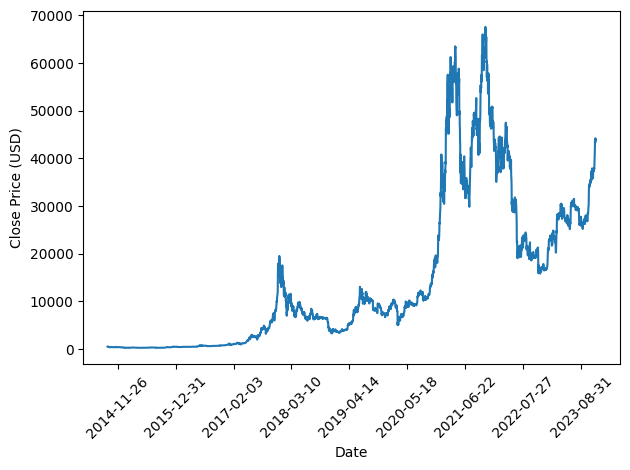

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Plot data training & testing

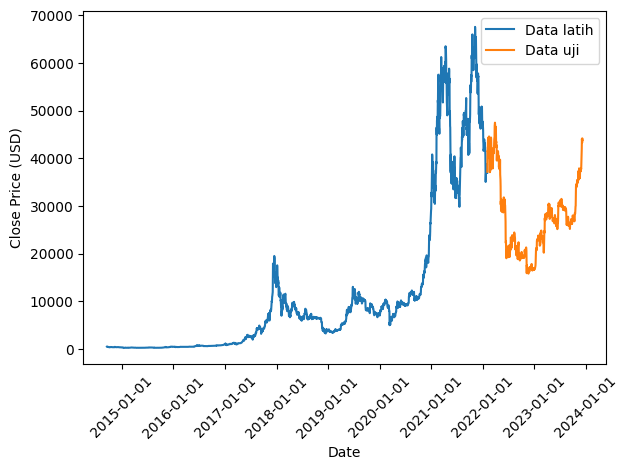

In [ ]:
total_rows = df.shape[0]
eighty_percent = int(0.8 * total_rows)
first_80_percent = df.head(eighty_percent)
last_20_percent = df.tail(total_rows - eighty_percent)
fig, ax = plt.subplots()
ax.plot(first_80_percent['Date'], first_80_percent['Close'], label='Data latih')
ax.plot(last_20_percent['Date'], last_20_percent['Close'], label='Data uji')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **LSTM Multioutput**

In [ ]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
def to_sequences_multi(data, seq_len, target_len):
    d = []
    for index in range(len(data) - seq_len - target_len + 1):
        d.append(data[index: index + seq_len+target_len-1])
    return np.array(d)

def preprocess_multi(data_raw, seq_len, target_len, train_split):
    data = to_sequences_multi(data_raw, seq_len, target_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-target_len, :]
    y_train = data[:num_train, -target_len:, :]
    X_test = data[num_train:, :-target_len, :]
    y_test = data[num_train:, -target_len:, :]
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_test  = y_test.reshape(y_test.shape[0], -1)
    return X_train, y_train, X_test, y_test

SEQ_LEN = 151
TARGET_LEN = 30
X_train_multi, y_train_multi, X_test_multi, y_test_multi =\
    preprocess_multi(scaled_close, SEQ_LEN, TARGET_LEN, train_split=0.80)

In [ ]:
X_train_multi.shape

(2552, 150, 1)

In [ ]:
y_train_multi.shape

(2552, 30)

In [ ]:
X_test_multi.shape

(639, 150, 1)

In [ ]:
y_test_multi.shape

(639, 30)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
 input_shape=(SEQ_LEN-1,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
 dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 150, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
BATCH_SIZE = 64
history = model.fit(
 X_train_multi,
 y_train_multi,
 epochs=50,
 batch_size=BATCH_SIZE,
 shuffle=False,
 validation_split=0.1
)
model.evaluate(X_test_multi, y_test_multi)

Epoch 1/50
36/36 [==============================] - 17s 258ms/step - loss: 0.0130 - val_loss: 0.0630
Epoch 2/50
36/36 [==============================] - 9s 237ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 3/50
36/36 [==============================] - 9s 255ms/step - loss: 0.0168 - val_loss: 0.1302
Epoch 4/50
36/36 [==============================] - 7s 207ms/step - loss: 0.0089 - val_loss: 0.0119
Epoch 5/50
36/36 [==============================] - 9s 256ms/step - loss: 0.0049 - val_loss: 0.0155
Epoch 6/50
36/36 [==============================] - 10s 285ms/step - loss: 0.0084 - val_loss: 0.0541
Epoch 7/50
36/36 [==============================] - 8s 224ms/step - loss: 0.0057 - val_loss: 0.0160
Epoch 8/50
36/36 [==============================] - 9s 251ms/step - loss: 0.0052 - val_loss: 0.0248
Epoch 9/50
36/36 [==============================] - 8s 221ms/step - loss: 0.0046 - val_loss: 0.0162
Epoch 10/50
36/36 [==============================] - 9s 233ms/step - loss: 0.0052 - val_loss: 0.02

0.012221171520650387

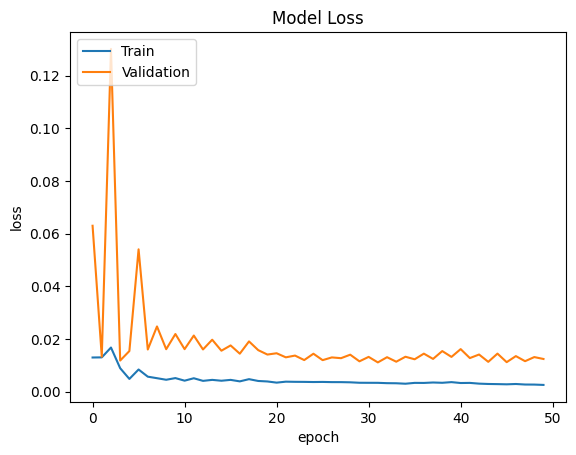

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_hat = model.predict(X_test_multi)
y_test_inverse = scaler.inverse_transform(y_test_multi)
y_hat_inverse = scaler.inverse_transform(y_hat)

20/20 [==============================] - 2s 44ms/step


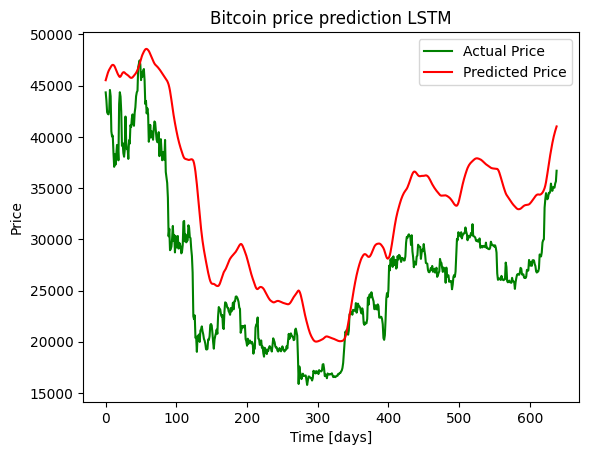

In [ ]:
y_test_single = y_test_inverse[:, 0]
plt.plot(y_test_single,label='Actual Price', color='green')
plt.plot(y_hat_inverse, label='Predicted Price', color='red')
plt.title('Bitcoin price prediction LSTM')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend()
plt.show();

In [ ]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = calculate_mape(y_test_single, y_hat_inverse)
print(f"MAPE: {mape:.2f}%")

MAPE: 42.57%


In [ ]:
def kajian_seq_len(seq_len):
    np.random.seed(88)
    X_train_multi, y_train_multi, X_test_multi, y_test_multi =\
        preprocess_multi(scaled_close, seq_len, TARGET_LEN, train_split=0.80)
    model = tf.keras.Sequential()
    model.add(layers.LSTM(units=32, return_sequences=True,
                          input_shape=(seq_len-1, 1), dropout=0.2))
    model.add(layers.LSTM(units=32, return_sequences=True, dropout=0.2))
    model.add(layers.LSTM(units=32, dropout=0.2))
    model.add(layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    BATCH_SIZE = 64
    history = model.fit(
        X_train_multi,
        y_train_multi,
        epochs=50,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.1
    )
    model.evaluate(X_test_multi, y_test_multi)
    y_hat = model.predict(X_test_multi)
    y_test_inverse = scaler.inverse_transform(y_test_multi)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    y_test_single = y_test_inverse[:, 0]
    mape = calculate_mape(y_test_single, y_hat_inverse)
    return mape

# **LSTM Singleoutput**

In [ ]:
SEQ_LEN = 151
TARGET_LEN = 1

In [ ]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
def to_sequences_single(data, seq_len, target_len):
    d = []
    for index in range(len(data) - seq_len - target_len + 1):
        d.append(data[index: index + seq_len + target_len - 1])
    return np.array(d)

def preprocess_single(data_raw, seq_len, target_len, train_split):
    data = to_sequences_single(data_raw, seq_len, target_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-target_len, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-target_len, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
np.random.seed(88)
X_train_single, y_train_single, X_test_single, y_test_single = \
    preprocess_single(scaled_close, SEQ_LEN, TARGET_LEN, train_split=0.80)

In [ ]:
X_train_single.shape

(2576, 150, 1)

In [ ]:
y_train_single.shape

(2576, 1)

In [ ]:
X_test_single.shape

(644, 150, 1)

In [ ]:
y_test_single.shape

(644, 1)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.LSTM(units=32, return_sequences=True,
 input_shape=(SEQ_LEN-1,1), dropout=0.2))
model.add(layers.LSTM(units=32, return_sequences=True,
 dropout=0.2))
model.add(layers.LSTM(units=32, dropout=0.2))
model.add(layers.Dense(units=1))
model.summary()
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 150, 32)           8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.evaluate(X_test_single, y_test_single)

21/21 [==============================] - 3s 55ms/step - loss: 0.1442


0.14418283104896545

In [ ]:
BATCH_SIZE = 64
history = model.fit(
    X_train_single,
    y_train_single,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
37/37 [==============================] - 15s 211ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 2/50
37/37 [==============================] - 6s 170ms/step - loss: 0.0125 - val_loss: 0.0382
Epoch 3/50
37/37 [==============================] - 8s 209ms/step - loss: 0.0174 - val_loss: 0.0864
Epoch 4/50
37/37 [==============================] - 6s 170ms/step - loss: 0.0123 - val_loss: 0.0050
Epoch 5/50
37/37 [==============================] - 8s 210ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 6/50
37/37 [==============================] - 6s 169ms/step - loss: 0.0194 - val_loss: 0.1662
Epoch 7/50
37/37 [==============================] - 8s 208ms/step - loss: 0.0136 - val_loss: 0.0373
Epoch 8/50
37/37 [==============================] - 6s 174ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 9/50
37/37 [==============================] - 8s 205ms/step - loss: 0.0112 - val_loss: 0.0947
Epoch 10/50
37/37 [==============================] - 7s 181ms/step - loss: 0.0053 - val_loss: 0.007

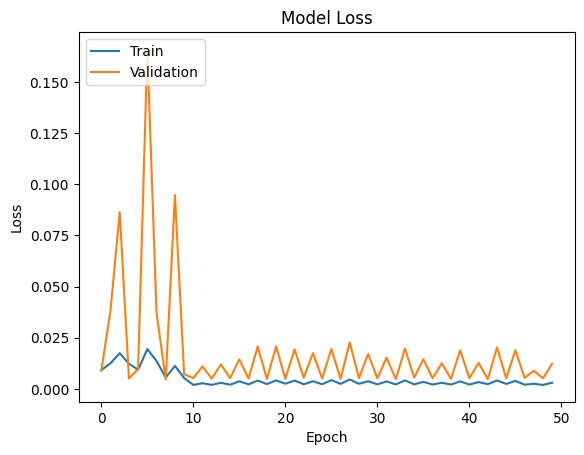

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_single = model.predict(X_test_single)
y_test_single_inverse = scaler.inverse_transform(y_test_single)
y_hat_single_inverse = scaler.inverse_transform(y_hat_single)

21/21 [==============================] - 2s 38ms/step


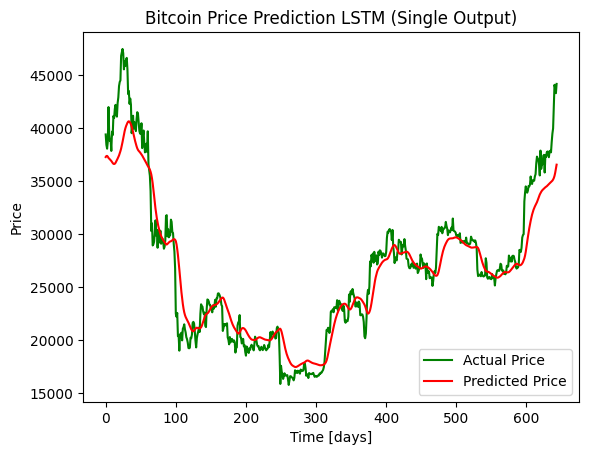

In [ ]:
plt.plot(y_test_single_inverse, label='Actual Price', color='green')
plt.plot(y_hat_single_inverse, label='Predicted Price', color='red')
plt.title('Bitcoin Price Prediction LSTM (Single Output)')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = calculate_mape(y_test_single_inverse, y_hat_single_inverse)
print(f"MAPE: {mape:.2f}%")

MAPE: 5.98%
